In [1]:
import os
os.makedirs('Images', exist_ok=True)

In [2]:
import spacy, nltk, joblib, re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

dff=pd.read_csv('Data/movie_reviews_v2.csv', index_col=0)
dff.head()

,movie_id,imdb_id,original_title,review,rating
review_id,,,,,
64ecc16e83901800af821d50,843,tt0118694,花樣年華,This is a fine piece of cinema from Wong Kar-W...,7.0
57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love...",9.0
5bb5ac829251410dcb00810c,7443,tt0120630,Chicken Run,Made my roommate who hates stop-motion animati...,6.0
5f0c53a013a32000357ec505,7443,tt0120630,Chicken Run,A very good stop-motion animation!\r\n\r\n<em>...,8.0
64ecc027594c9400ffe77c91,7443,tt0120630,Chicken Run,"Ok, there is an huge temptation to riddle this...",7.0


## Load and inspect the dataset.

- How many reviews?
- What does the distribution of ratings look like?
- Any null values?

In [3]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8650 entries, 64ecc16e83901800af821d50 to 653df83bc8a5ac011d6d5767
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   movie_id        8650 non-null   int64  
 1   imdb_id         8650 non-null   object 
 2   original_title  8650 non-null   object 
 3   review          8650 non-null   object 
 4   rating          7454 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 405.5+ KB


In [4]:
# Dropping Null values 
dff = dff.dropna(subset=["rating"])

In [5]:
dff.isna().sum()

movie_id          0
imdb_id           0
original_title    0
review            0
rating            0
dtype: int64

In [6]:
dff.duplicated().sum()

35

In [7]:
dff = dff.drop_duplicates()
dff.duplicated().sum()

0

In [8]:
dff['rating'].value_counts()

7.0     1567
6.0     1380
8.0     1252
5.0      728
9.0      614
10.0     562
4.0      511
1.0      284
3.0      253
2.0      152
7.5       27
8.5       23
6.5       22
9.5       15
0.5       10
5.5        6
3.5        4
4.5        4
1.5        3
2.5        2
Name: rating, dtype: int64

## Keep high-rating and low-rating groups, while middle ratings between 4 and 9 will be excluded from the analysis.

In [9]:
highrate= dff['rating']>=9
lowrate= dff['rating']<=4
df= dff[highrate | lowrate].copy()
# check the number of reviews left
len(df)

2410

In [10]:
# Increase column width
pd.set_option('display.max_colwidth', None)
df.head()

,movie_id,imdb_id,original_title,review,rating
review_id,,,,,
57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy animation.",9.0
57b2d23dc3a36837d7000b14,955,tt0120755,Mission: Impossible II,"The first underwhelmed me, but this one straight-up bored me. Again, of course seeing Hunt climb a mountain without a harness is impressive sure. And I even quite liked the idea behind the villain of the piece (though even that angle was woefully underdeveloped).\r\n\r\nEven setting it in predominantly Australia was enough to grab my attention, and that's saying something cause I'm pretty biased when it comes to that. I hear tell that _Mission: Impossible II_ is the low point in the series, and that at least is encouraging, because if anything afterwards is much worse than this one, I don't know if I'll be able to make it through to Rogue Nation.\r\n\r\n_Final rating:★½: - Boring/disappointing. Avoid if possible._",3.0
5e9120963679a10018375490,955,tt0120755,Mission: Impossible II,"After quite entertainign Mission Impossible I the second installment turned out ... terrible. As if the screenwriters didn't know how to fill the 2 hrs with action the overuse of heroic slow motion scenes is horrible. You almost might need a barf bag if you can't stand slo-mo every five seconds... for 15 seconds. I am amazed they did decide to push on with more M:I movies after this one, then again, these turned out much much better even if it would be hard to beat that lousy piece of crap of a movie.",2.0
608e2744d8cc4a0058dc4272,2621,tt0122459,Return to Me,"Okay, I will admit I can be a bit of an easy grader when it comes to romantic comedies, as long as they are witty with likable characters, don’t insult my intelligence and have suitable happy endings (I guess if they don’t end happily, they aren’t rom-coms).\r\n\r\nI saw this movie many years ago, but had forgotten just enough of it to keep it fresh for me. Like many movies, the plot relies on a huge coincidence or three. The story gets sappy and sentimental in places, is rather predictable and has too much religion to suit me, but that last thing may suit you just fine, praise be. It was co-written and directed by the actress Bonnie Hunt, who is a supporting character in the film.\r\n\r\nBut there is a spark of chemistry between the two lead characters, the dialogue is smart and sharp, and the movie is rich with its supporting cast, such as Jim Belushi, Robert Loggia and Archie Bunker - I mean Carroll O’Connor. Plus I have liked Minnie Driver since Circle of Friends. \r\n\r\nJust keep in mind this isn’t Hitchcock or Frank Capra stuff and doesn’t try to be. Just let it flow over you",9.0
6409202f0e441900e887a17b,4234,tt0134084,Scream 3,"**_Scream 3’s_ lackluster screenplay and unimaginative kills leave a film that is a bore to watch.**\r\n\r\nThe meta-narrative of trilogies throughout the film does not make up for how abysmal the plot was. This film creates so much lore for the past movies seemingly out of the blue, muddling up the continuity for shock value. It added very little to this film and felt forced. The entire plot point of Sidney’s mother being a former Hollywood actress was pretty lame, especially with the added plot point of her being sexually assaulted by a movie producer. It may be personal taste, but I absolutely despise when films add that plot point, as it feels incredibly hypocritical since it is something that genuinely happens to an industry, they are involved in. The love triangle between Gale, Dewey, and the Gale actress was pretty dumb and felt undeserved, as we have not seen Gale and Dewey actually together in any of the films.\r\n\r\nIn horror films, you can have a good movie with a terrible plot as long as the kills are great. Unfortunately, 

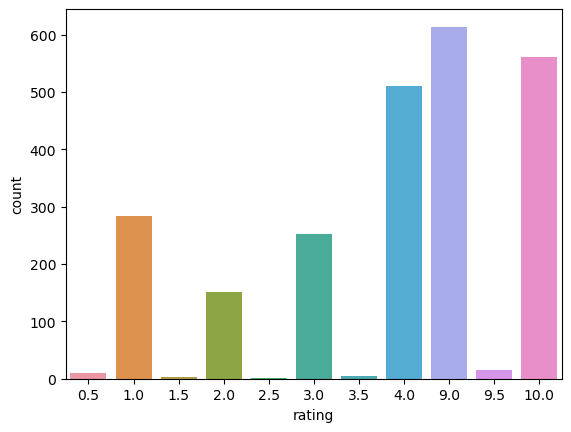

In [11]:
# How many of each star rating?
sns.countplot(data = df, x = 'rating');

In [12]:
def make_custom_nlp(
    disable=[], # choose from ['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']
    contractions=[],
    stopwords_to_add=[],
    stopwords_to_remove=[],
    spacy_model = "en_core_web_sm"
):
    
    # Load the English NLP model
    nlp = spacy.load(spacy_model, disable=disable)
    
    # Adding Special Cases 
    # Loop through the contractions list and add special cases
    for contraction in contractions:
        special_case = [{"ORTH": contraction}]
        nlp.tokenizer.add_special_case(contraction, special_case)
    
    # Adding stopwords
    for word in stopwords_to_add:
        # Set the is_stop attribute for the word in the vocab dict to true.
        nlp.vocab[
            word
        ].is_stop = True  # this determines spacy's treatmean of the word as a stop word
        # Add the word to the list of stopwords (for easily tracking stopwords)
        nlp.Defaults.stop_words.add(word)
    
    # Removing Stopwords
    for word in stopwords_to_remove:
        
        # Ensure the words are not recognized as stopwords
        nlp.vocab[word].is_stop = False
        nlp.Defaults.stop_words.discard(word)
        
    return nlp

def batch_preprocess_texts(
    texts,
    nlp=None,
    remove_stopwords=True,
    remove_punct=True,
    use_lemmas=False,
    batch_size=50,
    n_process=-1,
):

    # from tqdm.notebook import tqdm
    from tqdm import tqdm

    if nlp is None:
        nlp = spacy.load("en_core_web_sm")

    processed_texts = []

    for doc in tqdm(nlp.pipe(texts, batch_size=batch_size, n_process=n_process)):
        tokens = []
        for token in doc:
            # Check if should remove stopwords and if token is stopword
            if (remove_stopwords == True) and (token.is_stop == True):
                # Continue the loop with the next token
                continue

            # Check if should remove stopwords and if token is stopword
            if (remove_punct == True) and (token.is_punct == True):
                continue

            # Check if should remove stopwords and if token is stopword
            if (remove_punct == True) and (token.is_space == True):
                continue

            
            ## Determine final form of output list of tokens/lemmas
            if use_lemmas:
                tokens.append(token.lemma_.lower())
            else:
                tokens.append(token.text.lower())

        processed_texts.append(tokens)
    return processed_texts


In [13]:
# Customize the nlp pipeline
function_nlp = make_custom_nlp(    
    disable=['ner', 'parser'],
    spacy_model = "en_core_web_sm")
# call preprocessing function with custom nlp pipeline
df['tokens'] = batch_preprocess_texts(df['review'], nlp = function_nlp)
df.head()

2410it [00:41, 57.73it/s] 


,movie_id,imdb_id,original_title,review,rating,tokens
review_id,,,,,,
57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy animation.",9.0,"[guilty, pleasure, personally, love, great, escape, works, seen, years, rightfully, esteemed, british, animation, company, highly, recommended, children, adults, enjoy, animation]"
57b2d23dc3a36837d7000b14,955,tt0120755,Mission: Impossible II,"The first underwhelmed me, but this one straight-up bored me. Again, of course seeing Hunt climb a mountain without a harness is impressive sure. And I even quite liked the idea behind the villain of the piece (though even that angle was woefully underdeveloped).\r\n\r\nEven setting it in predominantly Australia was enough to grab my attention, and that's saying something cause I'm pretty biased when it comes to that. I hear tell that _Mission: Impossible II_ is the low point in the series, and that at least is encouraging, because if anything afterwards is much worse than this one, I don't know if I'll be able to make it through to Rogue Nation.\r\n\r\n_Final rating:★½: - Boring/disappointing. Avoid if possible._",3.0,"[underwhelmed, straight, bored, course, seeing, hunt, climb, mountain, harness, impressive, sure, liked, idea, villain, piece, angle, woefully, underdeveloped, setting, predominantly, australia, grab, attention, saying, cause, pretty, biased, comes, hear, tell, mission, impossible, ii, low, point, series, encouraging, worse, know, able, rogue, nation, final, rating:, ★, ½, boring, disappointing, avoid, possible]"
5e9120963679a10018375490,955,tt0120755,Mission: Impossible II,"After quite entertainign Mission Impossible I the second installment turned out ... terrible. As if the screenwriters didn't know how to fill the 2 hrs with action the overuse of heroic slow motion scenes is horrible. You almost might need a barf bag if you can't stand slo-mo every five seconds... for 15 seconds. I am amazed they did decide to push on with more M:I movies after this one, then again, these turned out much much better even if it would be hard to beat that lousy piece of crap of a movie.",2.0,"[entertainign, mission, impossible, second, installment, turned, terrible, screenwriters, know, fill, 2, hrs, action, overuse, heroic, slow, motion, scenes, horrible, need, barf, bag, stand, slo, mo, seconds, 15, seconds, amazed, decide, push, m, movies, turned, better, hard, beat, lousy, piece, crap, movie]"
608e2744d8cc4a0058dc4272,2621,tt0122459,Return to Me,"Okay, I will admit I can be a bit of an easy grader when it comes to romantic comedies, as long as they are witty with likable characters, don’t insult my intelligence and have suitable happy endings (I guess if they don’t end happily, they aren’t rom-coms).\r\n\r\nI saw this movie many years ago, but had forgotten just enough of it to keep it fresh for me. Like many movies, the plot relies on a huge coincidence or three. The story gets sappy and sentimental in places, is rather predictable and has too much religion to suit me, but that last thing may suit you just fine, praise be. It was co-written and directed by the actress Bonnie Hunt, who is a supporting character in the film.\r\n\r\nBut there is a spark of chemistry between the two lead characters, the dialogue is smart and sharp, and the movie is rich with its supporting cast, such as Jim Belushi, Robert Loggia and Archie Bunker - I mean Carroll O’Connor. Plus I have liked Minnie Driver since Circle of Friends. \r\n\r\nJust keep in mind this isn’t Hitchcock or Frank Capra stuff and doesn’t try to be. Just let it flow over you",9.0,"[okay, admit, bit, easy, grader, comes, romantic, comedies, long, witty, likable, characters, insult, intelligence, suitable, happy, endings, guess, end, happily, rom, coms, saw, mo

In [14]:
# call preprocessing function with custom nlp pipeline
df['lemmas'] = batch_preprocess_texts(df['review'], nlp = function_nlp, use_lemmas=True)
df.head()

2410it [00:42, 56.27it/s] 


,movie_id,imdb_id,original_title,review,rating,tokens,lemmas
review_id,,,,,,,
57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy animation.",9.0,"[guilty, pleasure, personally, love, great, escape, works, seen, years, rightfully, esteemed, british, animation, company, highly, recommended, children, adults, enjoy, animation]","[guilty, pleasure, personally, love, great, escape, work, see, year, rightfully, esteem, british, animation, company, highly, recommend, child, adult, enjoy, animation]"
57b2d23dc3a36837d7000b14,955,tt0120755,Mission: Impossible II,"The first underwhelmed me, but this one straight-up bored me. Again, of course seeing Hunt climb a mountain without a harness is impressive sure. And I even quite liked the idea behind the villain of the piece (though even that angle was woefully underdeveloped).\r\n\r\nEven setting it in predominantly Australia was enough to grab my attention, and that's saying something cause I'm pretty biased when it comes to that. I hear tell that _Mission: Impossible II_ is the low point in the series, and that at least is encouraging, because if anything afterwards is much worse than this one, I don't know if I'll be able to make it through to Rogue Nation.\r\n\r\n_Final rating:★½: - Boring/disappointing. Avoid if possible._",3.0,"[underwhelmed, straight, bored, course, seeing, hunt, climb, mountain, harness, impressive, sure, liked, idea, villain, piece, angle, woefully, underdeveloped, setting, predominantly, australia, grab, attention, saying, cause, pretty, biased, comes, hear, tell, mission, impossible, ii, low, point, series, encouraging, worse, know, able, rogue, nation, final, rating:, ★, ½, boring, disappointing, avoid, possible]","[underwhelme, straight, bore, course, see, hunt, climb, mountain, harness, impressive, sure, like, idea, villain, piece, angle, woefully, underdeveloped, set, predominantly, australia, grab, attention, say, cause, pretty, biased, come, hear, tell, mission, impossible, ii, low, point, series, encouraging, bad, know, able, rogue, nation, final, rating:, ★, ½, boring, disappointing, avoid, possible]"
5e9120963679a10018375490,955,tt0120755,Mission: Impossible II,"After quite entertainign Mission Impossible I the second installment turned out ... terrible. As if the screenwriters didn't know how to fill the 2 hrs with action the overuse of heroic slow motion scenes is horrible. You almost might need a barf bag if you can't stand slo-mo every five seconds... for 15 seconds. I am amazed they did decide to push on with more M:I movies after this one, then again, these turned out much much better even if it would be hard to beat that lousy piece of crap of a movie.",2.0,"[entertainign, mission, impossible, second, installment, turned, terrible, screenwriters, know, fill, 2, hrs, action, overuse, heroic, slow, motion, scenes, horrible, need, barf, bag, stand, slo, mo, seconds, 15, seconds, amazed, decide, push, m, movies, turned, better, hard, beat, lousy, piece, crap, movie]","[entertainign, mission, impossible, second, installment, turn, terrible, screenwriter, know, fill, 2, hrs, action, overuse, heroic, slow, motion, scene, horrible, need, barf, bag, stand, slo, mo, second, 15, second, amazed, decide, push, m, movie, turn, well, hard, beat, lousy, piece, crap, movie]"
608e2744d8cc4a0058dc4272,2621,tt0122459,Return to Me,"Okay, I will admit I can be a bit of an easy grader when it comes to romantic comedies, as long as they are witty with likable characters, don’t insult my intelligence and have suitable happy endings (I guess if they don’t end happily, they aren’t rom-coms).\r\n\r\nI saw this movie many years ago, but had forgotten just enough of it to keep it fresh for me. Like many movies, the plot relies on a huge c

In [15]:
# check artifacts e.g. HTML code like "href"
artifact=df['review'].str.contains('href')
artifact.sum()

16

In [16]:
df=df[~artifact]
len(df)

2394

In [17]:
# Join list of tokens into a string with spaces between each token
df['tokens-joined'] = df['tokens'].map(lambda x: " ".join(x))
# Join list of lemmas into a string with spaces between each lemma
df['lemmas-joined'] = df['lemmas'].map(lambda x: " ".join(x))

In [18]:
## creating a dictionary of the whole dataframe
export = {'df':df }
# saving the export dict as a joblib file
joblib.dump(export, 'Data/movie_reviews_v2.joblib')

['Data/movie_reviews_v2.joblib']

In [19]:
#  loading it back in 
loaded = joblib.load('Data/movie_reviews_v2.joblib')
df = loaded['df']

## EDA and Visualization

In [20]:
highrate= df['rating']>=9
lowrate= df['rating']<=4
 
high_reviews_lemmas= " ".join( df.loc[highrate, 'lemmas-joined'])
print(high_reviews_lemmas[:1000],"\n")
low_reviews_lemmas = " ".join( df.loc[lowrate, 'lemmas-joined'])
print(low_reviews_lemmas[:1000],"\n")

guilty pleasure personally love great escape work see year rightfully esteem british animation company highly recommend child adult enjoy animation okay admit bit easy grader come romantic comedy long witty likable character insult intelligence suitable happy ending guess end happily rom com see movie year ago forget fresh like movie plot rely huge coincidence story get sappy sentimental place predictable religion suit thing suit fine praise co write direct actress bonnie hunt support character film spark chemistry lead character dialogue smart sharp movie rich support cast jim belushi robert loggia archie bunker mean carroll o’connor plus like minnie driver circle friends mind hitchcock frank capra stuff try let flow people scared day compliment be got to worry pitch black direct david twohy collectively write twohy ken jim wheat star vin diesel radha mitchell cole hauser keith david lewis fitz gerald claudia black rhiana griffith music graeme revell cinematography david eggby year 20

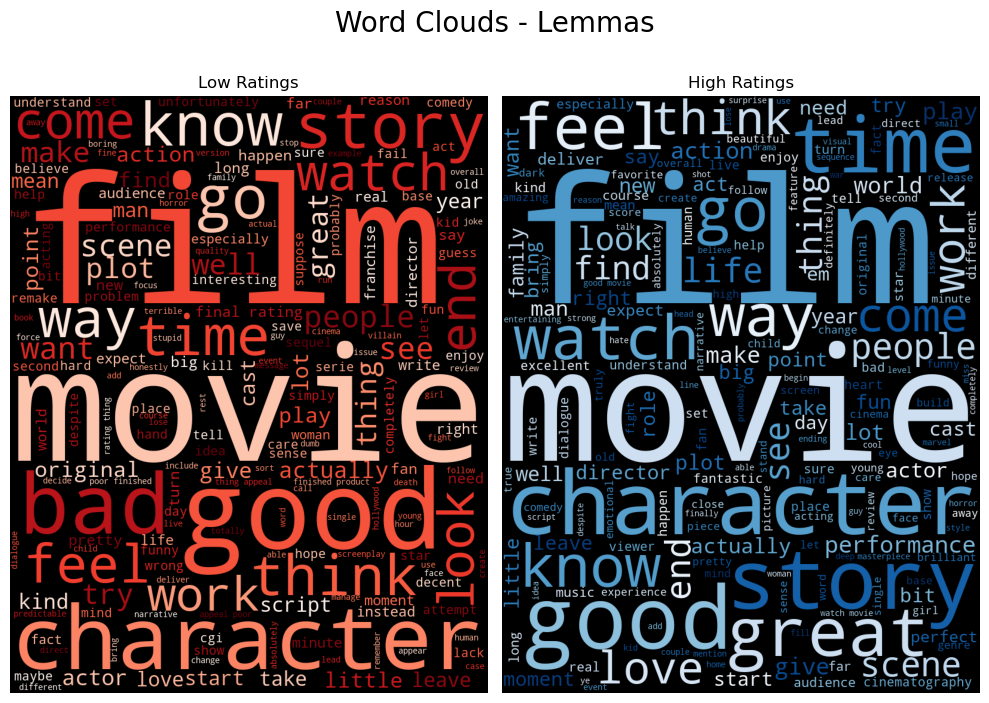

In [21]:
from wordcloud import WordCloud

# Make word clouds of lemmas with custom stopwords
# Create an instance of a WordCloud and use the generate method
low_cloud = WordCloud(random_state = 42,
                      width = 800,
                      height = 1000,
                      min_word_length = 2, colormap="Reds",
                      #stopwords = custom_stopwords
                     ).generate(low_reviews_lemmas)
high_cloud = WordCloud(random_state = 42,
                       width = 800,
                       height= 1000,
                       min_word_length = 2, colormap="Blues",
                       #stopwords = custom_stopwords
                      ).generate(high_reviews_lemmas)
# Plot the wordclouds side by side
fig, axes = plt.subplots(ncols=2, figsize=(10, 7))
axes[0].imshow(low_cloud)
axes[0].set_title("Low Ratings")
axes[1].imshow(high_cloud)
axes[1].set_title("High Ratings")
[ax.axis('off') for ax in axes]
fig.tight_layout();
fig.suptitle('Word Clouds - Lemmas', fontsize=20, y=1.05);

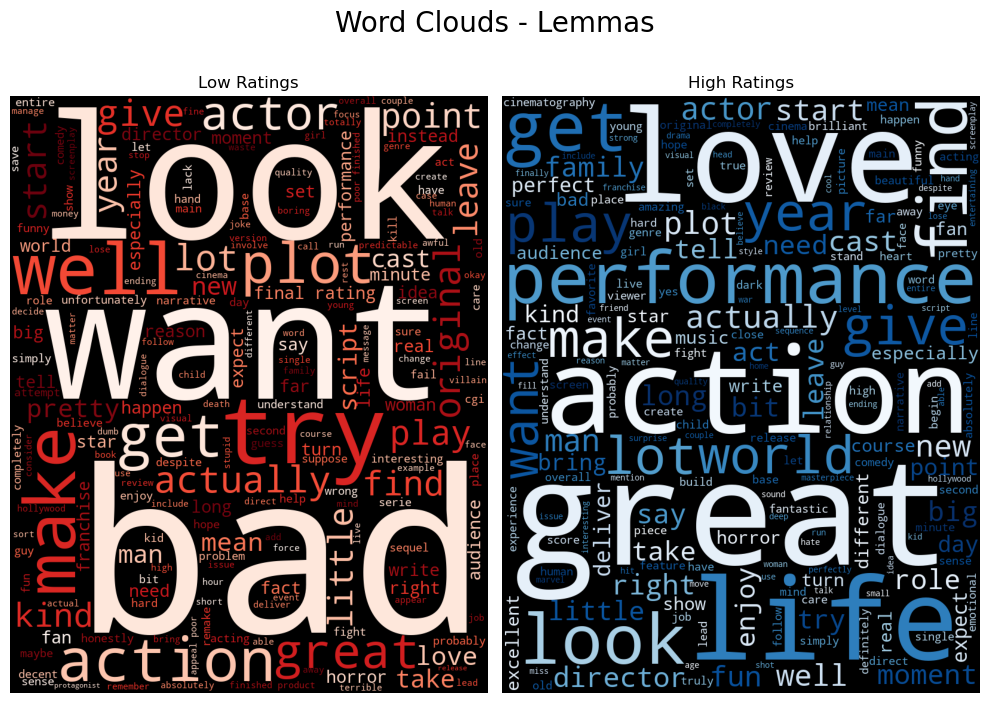

In [22]:
# remove words are common in both groups
custom_stopwords = ['movie', 'film', 'go', 'think', 'character', 'come', 'know', 'feel', 'good', 'story',
                    'like', 'watch', 'time', 'way', 'end', 'people', 'thing', 'see', 'work','scene']
low_cloud = WordCloud(random_state = 42,
                      width = 800,
                      height = 1000,
                      min_word_length = 3, colormap="Reds",
                      stopwords = custom_stopwords
                     ).generate(low_reviews_lemmas)
high_cloud = WordCloud(random_state = 42,
                       width = 800,
                       height= 1000,
                       min_word_length = 3, colormap="Blues",
                       stopwords = custom_stopwords
                      ).generate(high_reviews_lemmas)
# Plot the wordclouds side by side
fig, axes = plt.subplots(ncols=2, figsize=(10, 7))
axes[0].imshow(low_cloud)
axes[0].set_title("Low Ratings")
axes[1].imshow(high_cloud)
axes[1].set_title("High Ratings")
[ax.axis('off') for ax in axes]
fig.tight_layout();
fig.suptitle('Word Clouds - Lemmas', fontsize=20, y=1.05);
fig.savefig('Images/wordcloud.png')

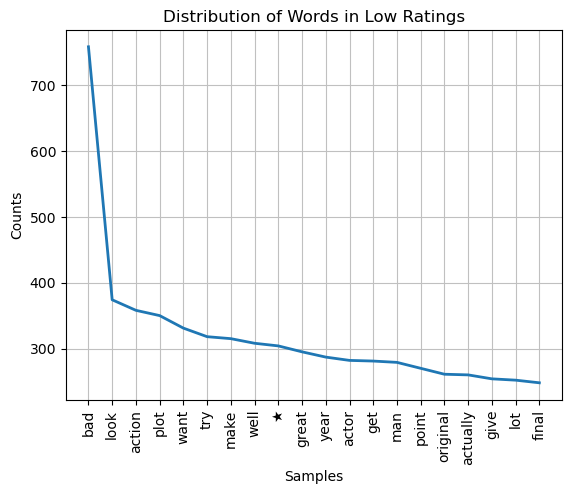

<Figure size 640x480 with 0 Axes>

In [23]:
from nltk.probability import FreqDist

# Split the lemmas into individual token words
low_review_lemmas_split = low_reviews_lemmas.split()
low_review_lemmas_splitt = [word for word in low_review_lemmas_split if word not in custom_stopwords]
# Pass the tokenized lemmas to the class constructor and plot the distribution 
low_dist = FreqDist(low_review_lemmas_splitt)
ax = low_dist.plot(20, title='Distribution of Words in Low Ratings')
plt.savefig('Images/low_review_freq_dist.png');

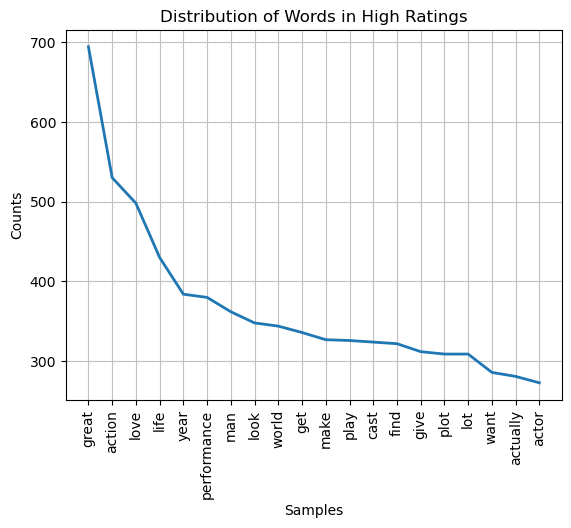

<Figure size 640x480 with 0 Axes>

In [24]:
# Split the lemmas into individual token words
high_review_lemmas_split = high_reviews_lemmas.split()
high_review_lemmas_splitt = [word for word in high_review_lemmas_split if word not in custom_stopwords]
# Pass the tokenized lemmas to the class constructor and plot the distribution 
high_dist = FreqDist(high_review_lemmas_splitt)
ax = high_dist.plot(20, title='Distribution of Words in High Ratings')
plt.savefig('Images/high_review_freq_dist.png');

In [25]:
def get_ngram_measures_finder(tokens, ngrams=2, measure='raw_freq', top_n=None, min_freq = 1,
                             words_colname='Words'):

    if ngrams == 4:
        MeasuresClass = nltk.collocations.QuadgramAssocMeasures
        FinderClass = nltk.collocations.QuadgramCollocationFinder
        
    elif ngrams == 3: 
        MeasuresClass = nltk.collocations.TrigramAssocMeasures
        FinderClass = nltk.collocations.TrigramCollocationFinder
    else:
        MeasuresClass = nltk.collocations.BigramAssocMeasures
        FinderClass = nltk.collocations.BigramCollocationFinder

    measures = MeasuresClass()
    
   
    finder = FinderClass.from_words(tokens)
    finder.apply_freq_filter(min_freq)
    if measure=='pmi':
        scored_ngrams = finder.score_ngrams(measures.pmi)
    else:
        measure='raw_freq'
        scored_ngrams = finder.score_ngrams(measures.raw_freq)

    df_ngrams = pd.DataFrame(scored_ngrams, columns=[words_colname, measure.replace("_",' ').title()])
    if top_n is not None:
        return df_ngrams.head(top_n)
    else:
        return df_ngrams


In [26]:
# find frequency values for bi-grams
ngram2_low = get_ngram_measures_finder(low_review_lemmas_split, top_n=20)
ngram2_high = get_ngram_measures_finder(high_review_lemmas_split, top_n=20)

In [27]:
print(ngram2_low.to_markdown(index=False), '\n')
print(ngram2_high.to_markdown(index=False), '\n')

| Words                       |    Raw Freq |
|:----------------------------|------------:|
| ('feel', 'like')            | 0.00118533  |
| ('final', 'rating')         | 0.00113225  |
| ('rating', '★')             | 0.00113225  |
| ('★', '★')                  | 0.00103495  |
| ('finished', 'product')     | 0.000849189 |
| ('look', 'like')            | 0.000849189 |
| ('appeal', 'poor')          | 0.000840344 |
| ('poor', 'finished')        | 0.000840344 |
| ('thing', 'appeal')         | 0.000840344 |
| ('★', 'thing')              | 0.000840344 |
| ('special', 'effect')       | 0.000610355 |
| ('watch', 'movie')          | 0.000592663 |
| ('bad', 'movie')            | 0.00055728  |
| ('★', '½')                  | 0.000521898 |
| ('movie', 'like')           | 0.000513052 |
| ('avoid', 'possible')       | 0.000504206 |
| ('boring', 'disappointing') | 0.000504206 |
| ('disappointing', 'avoid')  | 0.000504206 |
| ('½', 'boring')             | 0.000504206 |
| ('final', 'rating:')        | 0.

In [28]:
# find frequency values for tri-grams
ngram3_low = get_ngram_measures_finder(low_review_lemmas_split, ngrams=3, measure='pmi', top_n=20, min_freq = 3)
ngram3_high = get_ngram_measures_finder(high_review_lemmas_split, ngrams=3, measure='pmi', top_n=20, min_freq = 3)
ngram3_low

,Words,Pmi
0,"(taraji, p., henson)",30.403252
1,"(edgar, rice, burroughs)",29.251249
2,"(https://www.tinakakadelis.com, cinerama, dome/2021/12/28)",28.929321
3,"(guillermo, del, toro)",26.929321
4,"(chloë, grace, moretz)",26.836212
5,"(dirty, rotten, scoundrels)",26.791818
6,"(samuel, l., jackson)",26.791818
7,"(chris, do, santos)",26.618981
8,"(louisa, moore, www.screenzealots.com)",26.443894
9,"(unchanged, combination, operation)",26.206855


In [29]:
print(ngram3_low.to_markdown(index=False), '\n')
print(ngram3_high.to_markdown(index=False), '\n')

| Words                                                            |     Pmi |
|:-----------------------------------------------------------------|--------:|
| ('taraji', 'p.', 'henson')                                       | 30.4033 |
| ('edgar', 'rice', 'burroughs')                                   | 29.2512 |
| ('https://www.tinakakadelis.com', 'cinerama', 'dome/2021/12/28') | 28.9293 |
| ('guillermo', 'del', 'toro')                                     | 26.9293 |
| ('chloë', 'grace', 'moretz')                                     | 26.8362 |
| ('dirty', 'rotten', 'scoundrels')                                | 26.7918 |
| ('samuel', 'l.', 'jackson')                                      | 26.7918 |
| ('chris', 'do', 'santos')                                        | 26.619  |
| ('louisa', 'moore', 'www.screenzealots.com')                     | 26.4439 |
| ('unchanged', 'combination', 'operation')                        | 26.2069 |
| ('texas', 'chainsaw', 'massacre')                 

In [30]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# The download below only needs to be completed once
# nltk.download('vader_lexicon')

# Initialize the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

In [31]:
# VADER with raw text
df['sentiment_scores'] = df['review'].map(sia.polarity_scores)
# Convert the column of dictionaries into separate columns
review_scores = df['sentiment_scores'].apply(pd.Series)
# Join the new DataFrame with the original DataFrame
reviews = pd.concat([df, review_scores], axis=1).drop('sentiment_scores', axis=1)
reviews.head()

,movie_id,imdb_id,original_title,review,rating,tokens,lemmas,tokens-joined,lemmas-joined,neg,neu,pos,compound
review_id,,,,,,,,,,,,,
57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy animation.",9.0,"[guilty, pleasure, personally, love, great, escape, works, seen, years, rightfully, esteemed, british, animation, company, highly, recommended, children, adults, enjoy, animation]","[guilty, pleasure, personally, love, great, escape, work, see, year, rightfully, esteem, british, animation, company, highly, recommend, child, adult, enjoy, animation]",guilty pleasure personally love great escape works seen years rightfully esteemed british animation company highly recommended children adults enjoy animation,guilty pleasure personally love great escape work see year rightfully esteem british animation company highly recommend child adult enjoy animation,0.053,0.587,0.360,0.9450
57b2d23dc3a36837d7000b14,955,tt0120755,Mission: Impossible II,"The first underwhelmed me, but this one straight-up bored me. Again, of course seeing Hunt climb a mountain without a harness is impressive sure. And I even quite liked the idea behind the villain of the piece (though even that angle was woefully underdeveloped).\r\n\r\nEven setting it in predominantly Australia was enough to grab my attention, and that's saying something cause I'm pretty biased when it comes to that. I hear tell that _Mission: Impossible II_ is the low point in the series, and that at least is encouraging, because if anything afterwards is much worse than this one, I don't know if I'll be able to make it through to Rogue Nation.\r\n\r\n_Final rating:★½: - Boring/disappointing. Avoid if possible._",3.0,"[underwhelmed, straight, bored, course, seeing, hunt, climb, mountain, harness, impressive, sure, liked, idea, villain, piece, angle, woefully, underdeveloped, setting, predominantly, australia, grab, attention, saying, cause, pretty, biased, comes, hear, tell, mission, impossible, ii, low, point, series, encouraging, worse, know, able, rogue, nation, final, rating:, ★, ½, boring, disappointing, avoid, possible]","[underwhelme, straight, bore, course, see, hunt, climb, mountain, harness, impressive, sure, like, idea, villain, piece, angle, woefully, underdeveloped, set, predominantly, australia, grab, attention, say, cause, pretty, biased, come, hear, tell, mission, impossible, ii, low, point, series, encouraging, bad, know, able, rogue, nation, final, rating:, ★, ½, boring, disappointing, avoid, possible]",underwhelmed straight bored course seeing hunt climb mountain harness impressive sure liked idea villain piece angle woefully underdeveloped setting predominantly australia grab attention saying cause pretty biased comes hear tell mission impossible ii low point series encouraging worse know able rogue nation final rating: ★ ½ boring disappointing avoid possible,underwhelme straight bore course see hunt climb mountain harness impressive sure like idea villain piece angle woefully underdeveloped set predominantly australia grab attention say cause pretty biased come hear tell mission impossible ii low point series encouraging bad know able rogue nation final rating: ★ ½ boring disappointing avoid possible,0.186,0.704,0.110,-0.8724
5e9120963679a10018375490,955,tt0120755,Mission: Impossible II,"After quite entertainign Mission Impossible I the second installment turned out ... terrible. As if the screenwriters didn't know how to fill the 2 hrs with action the overuse of heroic slow motion scenes is horrible. You almost might need a barf bag if you can't stand slo-mo every five seconds... for 15 seconds. I am amazed they did decide to push on with more M:I movies after this one, then again, these turned out much much better even if it would be 

In [32]:
# Define filter for positive reviews
pos_sentiment_reviews = reviews['compound'] > 0
pos_sentiment_reviews.sum()

1611

In [33]:
reviews.loc[lowrate, 'compound'].mean()

-0.01246568144499179

In [34]:
reviews.loc[highrate, 'compound'].mean()

0.7002187074829932

In [35]:
# Identify reviews with a positive sentiment score that received low rating
filter_mismatch_A = lowrate & pos_sentiment_reviews
print(f' there are {sum(filter_mismatch_A)} reviews with a positive sentiment score that received a low rating')
pos_sent_low= reviews.loc[filter_mismatch_A, ['review','rating','compound']]
pos_sent_low.head()

 there are 574 reviews with a positive sentiment score that received a low rating


,review,rating,compound
review_id,,,
5dd0f0b6b76cbb00137ad8f4,"WHAT A GREAT CAST FOR SUCH A CHEAP FILM.\r\n\r\nDescription:\r\nThree college students base their class project around gossip and how fast it spreads, which soon spirals out of control.\r\n\r\nReview:\r\nGossip is a Dramatic Thriller that was made fifteen years too late. The story sounds like something that could have been believable in the 80's but not for the 2000s, rape kits and a thorough investigation solves the plot. It's pretty to look at and the cast is excellent but the rest of it is unbelievable.",4.0,0.8695
61fc416f5f4b73006c946bee,"Pretty typical movie from the early aughts with attractive twenty-somethings in the leads and bland ""rock"" pop music, alongside an overly dramatic score. The acting is so-so at best and really bad story to go along with a laughable ending. Led to two direct-to-video sequels that I'm really not too keen to revisit. **2.0/5**",4.0,0.6523
654b042c1ac2927b2ebddc17,"**An excuse to make a film full of women swaying seductively without a hint of softcore.**\r\n\r\nWhat can we say about a romantic film, with light touches of comedy, that spends most of its time showing us very attractive women in tight, short clothes, and bouncing around sensually in an atmosphere of mockery and debauchery worthy of a university graduation party? A lot of things. What leaves us no doubt? It is a film made with an openly and openly heterosexual audience in mind. Released in 2000, I don't know if the film would be possible today without being immediately accused of sexism and giving a stereotypical and sexualized image of women.\r\n\r\nLet's start by talking about the good things. One of them, perhaps the best, is the extraordinary soundtrack, which compiles excellent songs into one of the best non-original soundtracks of the decade: “The Right Kind of Wrong” and “Can't Fight the Moonlight” are so good that the entire we know them. The music is so important here that, in a sense, it is more of a music video than a film: the protagonist is an aspiring songwriter who tries to make it in the music market without much success, but who discovers that she sings well and becomes one of the main attractions. of a nightclub.\r\n\r\nThe scenarios are convincing enough for us to believe them, especially if it is known that there really is a bar of this type in New York (in fact, it seems that others in the same franchise have already opened). Even so, there is so much exaggeration at parties that it is, in my eyes, difficult to believe in a certified and legal commercial space. Minimally decent editing, but sometimes lax, and cinematography that relies too heavily on red tones complete, on a less positive note, the more technical aspects of this film.\r\n\r\nIn addition to the good songs, we have the beauty of the cast, with young and slender actresses, who make up for their inexperience with fantastic bodies and good dancing skills: Piper Perabo, Maria Bello, Tyra Banks, Izabella Miko, Bridget Moynahan and Adam Garcia. It's a shame that physical beauty doesn't translate into talent: as the cast wasn't chosen based on the actors' abilities, none of them offer an inspired performance. They are a bunch of complete scoundrels and the film, at this point, is very weak. In the interest of justice, it is imperative to save the renowned John Goodman, the only good actor here, who shows us what it is like to act in a character full of grace and quite comical.\r\n\r\nAll of these, however, are mere stumbling blocks on the long road of a production that could, even so, be frankly good if it told us a good story. It is in the script and the story told that the film falls to the ground like an aspiring model who breaks both heels while parading. When watching the film, I asked myself over and over again where the hell the script was, because all that, that whole trip to the city, to a future in show business, is so absolutely cliché and has already been repeated so much th

In [36]:
pos_sent_low[pos_sent_low['rating']==1]

,review,rating,compound
review_id,,,
4fce88ed19c29523e0000069,"After writing three high-praise reviews, I tried to think of the worst movie that I'd ever sat through and this movie came to mind, front and center. I've sat through plenty of ""chick flicks"" but even by chick flick standards this one is just horrible. (to give this a more modern reference, I rate this one below ""The Vow"" on the painful to watch scale. If The Vow is a broken femur, Dr. T and the Women is everlasting torment in the 9th circle of Hell.) \r\n\r\nI try to look for the good in any movie, and I have plenty of low budget favorites as well as many Hollywood, blockbuster favorites. I've actually seen Dr. T. and the Women, movie on people's ""Favorites"" lists and I scratch my head and the only conclusion I can come up with is that the people that made this movie and actually like this movie are infatuated with Richard Gere and he could just stand in front of a camera doing anything at random for 90 minutes and these persons would have a deep admiration of the film... As a movie there is just nothing here. It is an absolute piece of c. I honestly believe that this movie could cause brain damage. Honestly I generally like Richard Gere movies, be they chick flick or not, but this is just an abomination. And if you absolutely have to see Helen Hunt in a ""B"" movie checkout Trancers. At least there is no pretense.",1.0,0.9408
63bf69478efe7300a0e9ef0c,"Well, it's not one quality... but I like to do a thumbs up or thumbs down approach. If the movie entertains a thumbs up, if it doesn't a thumbs down. Seems simpler than debating on a 4, a 5, a 6, whatever.\r\n\r\nThis is also kind of why I want to be able to review individual actors, just so I can write a memo to Guy Peirce and tell him that he needs to stop doing period literary pieces and go back to making films that don't require ascots and puffs.\r\n\r\nAnd this brings me to the point in the review where I question why I know what the difference between an ascot and a puff are.\r\n\r\nAnyway, self-reflection aside, the problem is that it doesn't know if it wants to be a thrilling adventure novel that is best epitomized by the writings of Dumas in all his pulp adventure glory... or if the story lasted in popularity for a century or so too long and now has to be regarded as a drama and treated with all the seriousness of a mature literary classic.\r\n\r\nIt teases with both and never settles on either. It kind of comes across that Wolpert, the writer, understood that Dumas was a pulp adventure writer but Reynolds, the director, thought Dumas was as serious as Dante.\r\n\r\nIt makes you feel like you are sitting in two different worlds. It kind of feels like you are watching a movie that wants to be a fun adventure yarn about revenge and prison breaks but every time that beast tries to escaped, it's forced back into it's cage by directorial gods of pretentious pompery.\r\n\r\nThis is the type of movie that you'd get if the director of ""Taming of the Shrew"" thought everything Shakespeare wrote was ""Richard III""... it's unsettling how deadly serious it takes itself.",1.0,0.9810
63c21b16df857c00bc21fda5,"I don't know how to approach this one.\r\n\r\n""The Time Machine"" is one of those stories that, rereading it, beings back vivid memories. One of my best friends in high school loaned it to me, I stored it away in my backpack for about a month and then...when we had a field trip to The Board of Trade, I scrounged it out and read it on the train ride.\r\n\r\nIt was one of those stories that is so short I could rip through it in the hour and fifteen minutes between our small town and Chicago. To this day, every time I go back to it, it brings me back to 1997 and, to this day, I distinctly remember finishing it about the time the train stopped and I remember walking into the crowded city feeling like I was in a different world. The story had moved me out of reality so much Chicago seemed jarring.\r\n\r\nAnd the

In [37]:
filter_mismatch_B = highrate & ~pos_sentiment_reviews
print(f' there are {sum(filter_mismatch_B)} reviews with a negaive sentiment score that received a high rating')
neg_sent_high= reviews.loc[filter_mismatch_B, ['review','rating','compound']]
neg_sent_high.head()

 there are 139 reviews with a negaive sentiment score that received a high rating


,review,rating,compound
review_id,,,
5b92026d0e0a26609c005caa,"One of those few movies that most people don't care for, but I personally think is **criminally** underrated.\r\n\r\n_Final rating:★★★★½ - Ridiculously strong appeal. I can’t stop thinking about it._",9.0,-0.3391
5fed7c50ede1b0003e64eab9,"Dazzling Björk in this indictment against the death sentence, in tight close-ups. This film is a UFO, musical without being.",10.0,-0.5574
557c9680c3a368632300242e,"Shattering expose of the fallible human condition.\r\n\r\nWhat to say about Darren Aronofsky's Requiem for a Dream that hasn't been said already? Without doubt it's a film, that in spite of its high standing on the main movie sites, polarises opinions. It's a film that in simple terms follows four people through their addictions until the shattering denouement, but the journey is made more bleak by offering tantalising snatches of hope, the dreams of the protags offered up as some sort of goals for the addicts to cling on to - only for the narrative to stick in its rusty serrated blade to draw the lifeblood from the hapless hopefuls.\r\n\r\nArononfsky brings a multitude of technical skills to the party that emphasise the emotional discord on show. Standard split-screening is married up with rapid cutting, isolated framing, close ups, long tracking and Snorricam, all of which is sound tracked by Clint Mansell's haunting musical composition. All told it's an assault on all the senses and terrifying with it, boosted no end by Aronofsky getting top performances from his cast of actors. Love it or hate it, it's a film that simply can't be ignored, unsparing cinema produced by a most gifted director. 9/10",9.0,-0.7907
55acc12cc3a3682ff40098c3,"I'll see you soon!\r\n\r\nBefore taking off for Paris, Alex Browning has a vision that the plane is going to explode. Pannicking he gets off the plane and in the mêlée a teacher and a group of his class mates are forced off the flight, the plane goes on to explode in mid air, killing everyone on board. But pretty soon after the disaster strange accidents start to befall those who got off the plane, it seems that death is out to get them.\r\n\r\nWith the number of hugely disappointing teens in peril movies that were made post the success of Wes Craven's hugely successful Scream, it's refreshing to find one that was, well, refreshing. Not purporting to be anything other than a wickedly entertaining piece of horror based nonsense, Final Destination is inventive, funny and above all else, shock laden.\r\n\r\nFrom the opening, and terrifying air crash sequence to the clever and gross way that our protagonists shake hands with the grim reaper, this film is gloriously proud of its horror intent. One peak at the surnames of the characters will tell you just how into their horror roots the makers are here, whilst not a homage movie as such, James Wong and his team clearly know what makes a modern horror picture work.\r\n\r\nIf you find yourself complaining about the writing then you clearly are missing the point of Final Destination's existence, either that or you are in fact dead yourself! Four fun but vastly inferior sequels would follow, but really this is the one to watch, as good a 100 minutes of horror fun as you could wish to have. I dare you not to jump out your seat at least once! 9/10",9.0,-0.9920
5e94d6fd0792e100143ad07c,"There can't be such devils out there. \r\n\r\nThe Pledge is directed by Sean Penn and adapted to screenplay by Jerzy Kromolowski and Mary Olson-Kromolowski from Friedrich Dürrenmatt's novel, ""The Promise"". It stars Jack Nicholson, Robin Wright Penn, Aaron Eckhart, Sam Shepard, Patricia Clarkson, Helen Mirren, Tom Noonan, Benicio Del Toro, Mickey Rourke, Dale Dickey, Vanessa Redgrave and Harry Dean Stanton. Music is by Klaus Badelt and Hans Zimmer, and cinematography by Chris Menges.\r\n\r\nPolice chief Jerry Black (Nicholson) is literally on his last day before retitement. But during his leaving party news filters

There are many mismatches in Sentiment Analysis:
1) Sentiment Analysis with VADER is not perfect, and it may miss context that would impact the analysis.
2) Even an accurate sentiment analysis does not necessarily tell us the person's overall rating.
   
Especially, people may express their high expectations at first, leading to a positive sentiment.
However, after watching the movie, they may become disappointed and start to express complaints if they don't like it.

## what should someone do (or not do) if they want to make a highly-rated movie?

- List 3 things associated with high-rating reviews >>> 'comic book', 'special effects', 'action sequence'
- List 3 things associated with low-rating reviews >>> 'boring', 'taraji, p., henson', 'edgar, rice, burroughs'